# Evaluation

- Evaluate the model on the test set
- Plot the predictions
- Calculate the metrics

In [1]:
import os
import yaml
import pickle
from pathlib import Path
from datetime import datetime


# def pathlib_constructor(loader, node):
#     value = loader.construct_scalar(node)
#     return PosixPath(value)

# yaml.add_constructor('!<tag:yaml.org,2002:python/object/apply:pathlib.PosixPath>', pathlib_constructor)


import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch


from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.modelling.models import load_model_checkpoint
from fault_management_uds.data.dataset import load_data, get_sensor_dataset, load_conditions
from fault_management_uds.modelling.predict import predict
from fault_management_uds.plots import set_meaningful_xticks



from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, rain_gauges, condition_to_meta


data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
external_metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

2025-02-24 10:03:50.305 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2025-02-24 10:04:13.625562: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 10:04:14.241556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740387854.396251 2961778 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740387854.425041 2961778 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

## TODO: how often predicting above/below?

### Steps ahead mae average for comparision with other paper

In [2]:

save_folder = "transformer/_tests/final_model"

# set save folder to path object
save_folder = MODELS_DIR / save_folder

split = 0 # first split
relative_path = f'{split+1}_split/'

run_folder = save_folder / relative_path
eval_folder = run_folder / 'evaluation'

In [13]:
# load the output
data_type = "test"
with open(eval_folder / data_type / f'output.pkl', 'rb') as f:
    output = pickle.load(f)
output.keys(), output['predictions'].shape

(dict_keys(['predictions', 'targets', 'endogenous_vars', 'timestamps']),
 (866911, 1, 15))

In [14]:
# residuals
maes = np.abs(output['predictions'] - output['targets'])
# averare steps ahead
maes = maes.mean(axis=2)
maes = maes.flatten()
# average all predictions
maes = maes.mean(axis=0)

print(f"MAE: {np.round(maes, 5)}")

MAE: 0.00301


## Load

In [190]:
# def get_newest_run(save_dir, model_name):
#     save_folder = MODELS_DIR / model_name
#     # get all folders
#     folders = [folder for folder in os.listdir(save_folder) if os.path.isdir(save_folder / folder)]
#     # get the newest folder
#     newest_folder = max(folders, key=lambda x: os.path.getmtime(save_folder / x))
#     return save_folder / newest_folder

# # select a folder
# experiment_folder_name = '1_model_complexity'
# experiment_name = 'hidden_size=128_num_heads=2_num_layers=2_241221_1952'
# save_folder = MODELS_DIR / experiment_folder_name / experiment_name

# split = 0 # first split
# relative_path = f'{split+1}_split/'
# run_folder = save_folder / relative_path

# print(save_folder)

# # load the config
# config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
# print(f"Total runs: {config['dataset_args']['n_splits']}") 

# # run info for each split
# split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')

In [5]:
save_folder = "transformer/0_stages_summarized/6_final_selection"

In [6]:
# set save folder to path object
save_folder = MODELS_DIR / save_folder

split = 0 # first split
relative_path = f'{split+1}_split/'

run_folder = save_folder / relative_path
eval_folder = run_folder / 'evaluation'

# Get relevant indo
config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
config['num_workers'] = 0
#config['predict_steps_ahead'] = args.predict_steps_ahead
# load pkl _with cpu
split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')
run_info = split_info[split]

Get the split info

In [7]:

# get the experiment to load
run_info = split_info[split]    
#  if the best_model_path, last_model_path, top_k_best_model_paths are not relative paths, then convert them to relative paths
if '/' in run_info['best_model_path']:
    run_info['best_model_path'] = os.path.relpath(run_info['best_model_path'], run_folder)
    run_info['last_model_path'] = os.path.relpath(run_info['last_model_path'], run_folder)
    run_info['top_k_best_model_paths'] = {
        k: os.path.relpath(str(v), run_folder) for k, v in run_info['top_k_best_model_paths'].items()
    }

print(f"Training time: {run_info['training_time']} minuts")

# define paths
eval_folder = run_folder / 'evaluation'

Training time: 539.4848771770795 minuts


In [9]:
data_type = 'test'

## MAE

In [10]:
# load
step_MAEs = pd.read_csv(eval_folder / data_type / 'step_MAEs.csv', index_col=0)
step_MAEs

,Overall,G71F04R_Level2
Step,,
1,0.000911,0.000911
2,0.001358,0.001358
3,0.001752,0.001752
4,0.002089,0.002089
5,0.002389,0.002389
6,0.002668,0.002668
7,0.002931,0.002931
8,0.003175,0.003175
9,0.003404,0.003404


In [11]:
condition_MAEs = pd.read_csv(eval_folder / data_type / 'condition_MAEs.csv', index_col=[0, 1])
condition_MAEs[['Overall']].head(4)

Overall
Step Condition          
1    Overall    0.000911
     Rain       0.001543
     Extreme    0.001765
     Dry        0.000774

In [45]:
def visualize_steps_ahead(step_MAEs):
    # visualize each sensor
    plt.figure(figsize=(10, 3))
    for sensor in step_MAEs.columns:
        plt.plot(step_MAEs[sensor], label=sensor, alpha=0.7, marker='o')
    plt.xlabel('Step')
    plt.ylabel('MAE')
    # set limits
    plt.xlim(min(step_MAEs.index), max(step_MAEs.index))
    plt.legend()
    plt.show()

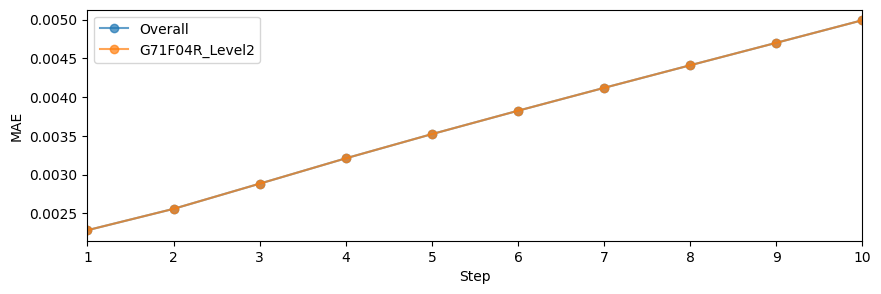

In [46]:
visualize_steps_ahead(step_MAEs)

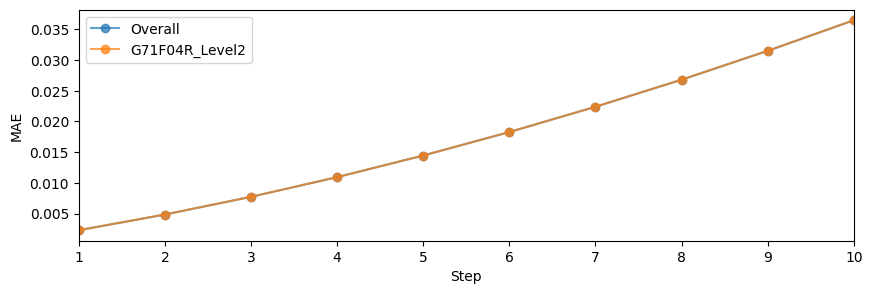

In [47]:
# cumulative
cumulative_MAE = step_MAEs.cumsum()
visualize_steps_ahead(cumulative_MAE)

In [48]:
def visualize_condition_MAE(condition_MAEs):
    # Reset index for plotting
    _condition_MAE = condition_MAEs.reset_index()
    # Pivot the data to have conditions as columns
    _condition_MAE = _condition_MAE.pivot(index='Step', columns='Condition', values='Overall')
    # Plot each condition
    fig, ax = plt.subplots(figsize=(10, 3))
    for condition_name in _condition_MAE.columns:
        _condition_MAE[condition_name].plot(kind='line', marker='o', ax=ax, color=condition_to_meta[condition_name]['color'], alpha=0.7)    

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('MAE')
    plt.xlim(min(_condition_MAE.index), max(_condition_MAE.index))
    plt.legend(title='Condition')
    plt.show()


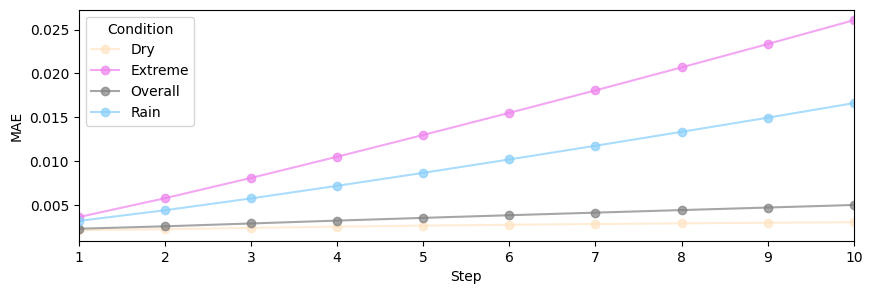

In [49]:
visualize_condition_MAE(condition_MAEs)

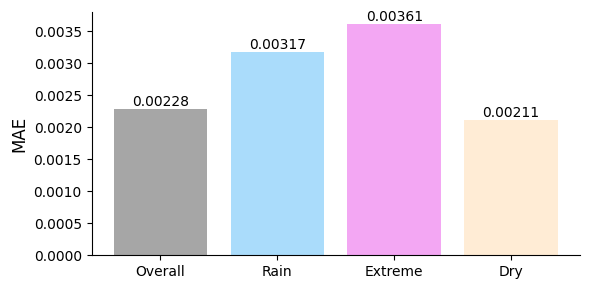

In [50]:
fig, ax = plt.subplots(figsize=(6, 3))
condition_names = condition_MAEs.index.get_level_values(1).unique()
for (_, row), condition_name in zip(condition_MAEs[['Overall']].head(4).iterrows(), condition_names):
    ax.bar(condition_name, row['Overall'], color=condition_to_meta[condition_name]['color'], label=condition_name, alpha=0.7)
    # add text to the bar
    ax.text(condition_name, row['Overall'], f"{row['Overall']:.5f}", ha='center', va='bottom')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylabel('MAE', fontsize=12)
plt.tight_layout()
plt.show()

## Visualize

In [176]:
def visualize_prediction(target, independent, pred_timestamps, prediction, metadata):

    # 2 subplots; rain, sensor
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ##############################
    # Rain data; constant
    ##############################
    # visualize exo data with colormap cool
    for exogenous_var in independent.columns:
        color = rain_gauge_color.get(exogenous_var, 'blue')
        #unit = metadata[metadata['IdMeasurement'] == exogenous_var]['UnitAlias'].values[0]

        axs[0].plot(independent[exogenous_var], 
                    label=exogenous_var, 
                    color=color, linewidth=1, linestyle='-', marker='o', markersize=1, alpha=1)
        # add unit to the y label
        #axs[0].set_ylabel(unit)
        axs[0].set_ylabel("Total Rainfall (mm)")

    
    axs[0].set_title('Rain data', fontsize=14); axs[0].set_ylabel('mm', fontsize=12); axs[0].legend(loc='upper left', fontsize="large")

    ##############################
    # Sensor data; variable
    ##############################
    # visualize target data
    axs[1].plot(target, label='Target', linewidth=1, linestyle='-', marker='o', markersize=1, alpha=1)
    # prediction
    axs[1].plot(pred_timestamps, prediction, label='Prediction', linewidth=1, linestyle='-', marker='o', markersize=1, alpha=1)
    # visualize
    unit = metadata[metadata['IdMeasurement'] == target.name]['UnitAlias'].values[0]
    axs[1].set_title('Sensor data', fontsize=12); axs[1].set_ylabel(unit, fontsize=12); axs[1].legend(loc='upper left', fontsize="large")
    ##############################
    # Format
    ##############################
    # Set x lim to the start and end of the event
    axs[-1].set_xlim(target.index[0], target.index[-1])
    set_meaningful_xticks(axs[-1], target.index[0], target.index[-1])

    return fig, axs


def visualize_condition_events(example_folder, model, dataset, data, 
        conditions, steps_ahead, scalers, metadata,
        n_events_per_condition=2,
        n_starts_per_event=5,
        save_plots=True,
        ):

    # Extract the relevant indices
    valid_timestamps = dataset.valid_timestamps

    # Define event period to visualize
    look_back_min = dataset.sequence_length
    look_forward_min = 60 + steps_ahead # 1 hour ahead

    # iterate over the conditions
    for condition_name, condition_data in conditions.items():
        if condition_name == 'Overall':
            continue
        
        print("#"*50)
        print(f"Visualizing condition: {condition_name}")
        print("#"*50)
        # sample the first period
        events = condition_data['df'].head(n_events_per_condition)
        
        # iterate over the events
        for _, event in events.iterrows():
            
            # Get the prediction indices
            start, end = event['start'], event['start']+pd.Timedelta(hours=3) # from start and to start + 3 hours for fixed duration
            event_timestamps = pd.date_range(start, end, freq='1min')
            relevant_indices = np.where(np.isin(valid_timestamps, event_timestamps))[0]
            prediction_indices = relevant_indices[::len(relevant_indices)//n_starts_per_event]

            # Get the plot data
            start = (pd.to_datetime(start) - pd.Timedelta(minutes=look_back_min)).floor('1h')
            end = (pd.to_datetime(end) + pd.Timedelta(minutes=look_forward_min)).ceil('1h')
            event_data = data.loc[start:end]

            for i, endogenous_var in enumerate(dataset.endogenous_vars):
                # Create a folder for each sensor
                sensor_folder = example_folder / endogenous_var
                os.makedirs(sensor_folder, exist_ok=True)

                for idx, i in enumerate(prediction_indices):
                    # Get the prediction
                    #pred_timestamps = valid_timestamps[i:i+steps_ahead]
                    pred_timestamps = pd.date_range(valid_timestamps[i], periods=steps_ahead, freq='1min')
                    valid_idx = dataset.valid_indices[i]
                    prediction, _ = predict(model, i, valid_idx, dataset, steps_ahead, scalers)

                    # Visualize
                    exogenous_vars = ["5425"] # only want rain, else use dataset.exogenous_vars
                    fig, ax = visualize_prediction(event_data[endogenous_var], event_data[exogenous_vars], pred_timestamps, prediction, metadata)
                    start_str = start.strftime("%Y-%m-%d")
                    # thigh layout
                    plt.tight_layout()
                    if save_plots:
                        fig.savefig(sensor_folder / f'{condition_name}_{start_str}_{idx+1}.png', dpi=150)
                        plt.close(fig)
                    else:
                        plt.show()
                


In [177]:
data_type = 'test'

In [178]:

from fault_management_uds.config import Config, get_additional_configurations
from fault_management_uds.data.dataset import load_data, get_datasets

metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

In [179]:
# metadata
# # insert rain gague to the metadata df
# rain_gauge_metadata = pd.DataFrame({'IdMeasurement': ['5425'], 'UnitAlias': ['mm'], 'Description': ['Rain gauge']})

# metadata = pd.concat([metadata, rain_gauge_metadata], axis=0)
# metadata

In [180]:
# Get the additional configurations
data = load_data([None, None], config['dataset_args']['data_file_path'], config['dataset_args'], 
                    data_type='complete',
                    data_group=config['dataset_args'].get('data_group', "clean"),
                    )
train_index, val_index, test_index = run_info['dataset_config']['train_index'], run_info['dataset_config']['val_index'], run_info['dataset_config']['test_index']
train_dataset, val_dataset, test_dataset, dataset_config = get_datasets(data, train_index, val_index, test_index, config['dataset_args'])
additional_configurations = get_additional_configurations(train_dataset)
# now delete this
del data, train_dataset, val_dataset, test_dataset

Validity: 323185 minutes are invalid.
Data validation passed.


In [181]:
model_to_load = config['training_args']['model_to_load']
model = load_model_checkpoint(run_folder, run_info, model_to_load, config, additional_configurations)

Using CPU
Model loaded from /work3/s194262/GitHub/fault_management_uds/models/transformer/0_stages_summarized/6_final_selection/1_split/epoch=07-val_loss=0.0000142.ckpt


In [182]:
# load the data
scalers = run_info['dataset_config']['scalers']
data = load_data([None, None], config['dataset_args']['data_file_path'], config['dataset_args'], data_type='complete')
# get the dataset
dataset = get_sensor_dataset(data, config['dataset_args'], 
    data_idx=run_info['dataset_config'][f'{data_type}_index'], 
    scalers=scalers,
    priority_weight=None, verbose=False, dataset_type=data_type)
# load the conditions
starttime, endtime = dataset.valid_timestamps[0], dataset.valid_timestamps[-1]
conditions = load_conditions(starttime, endtime)


##################################################
Visualizing condition: Rain
##################################################


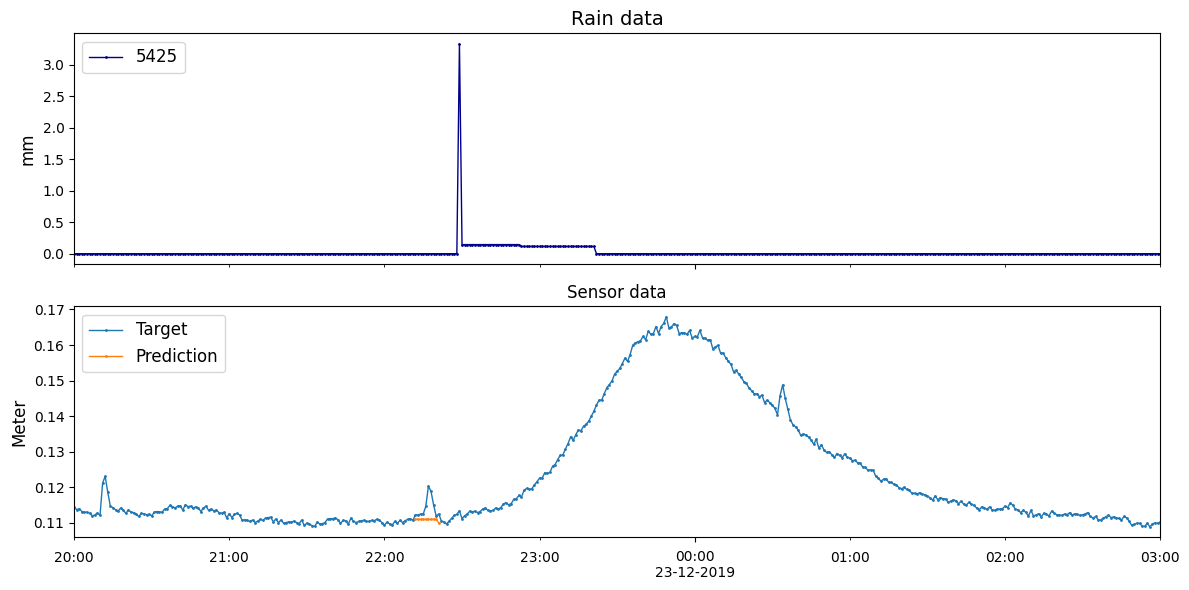

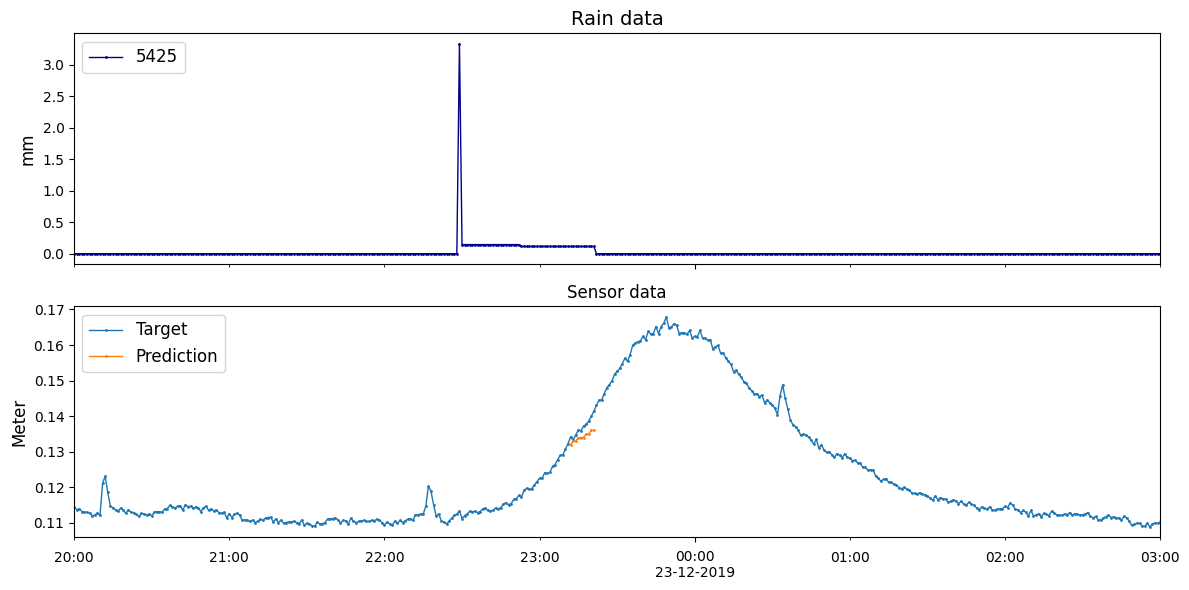

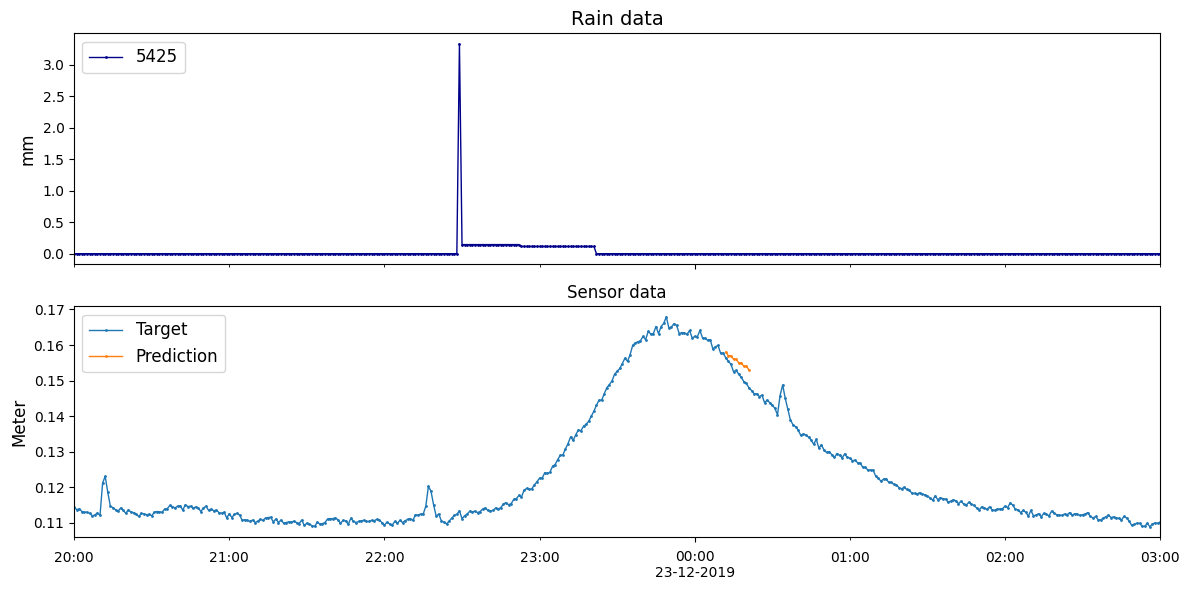

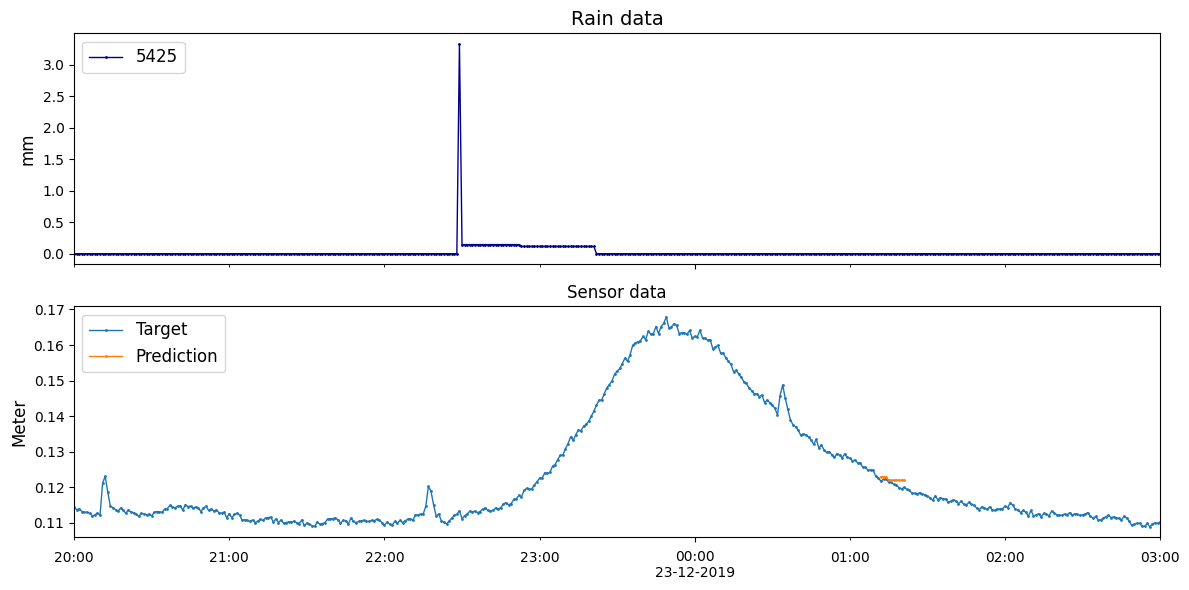

##################################################
Visualizing condition: Extreme
##################################################


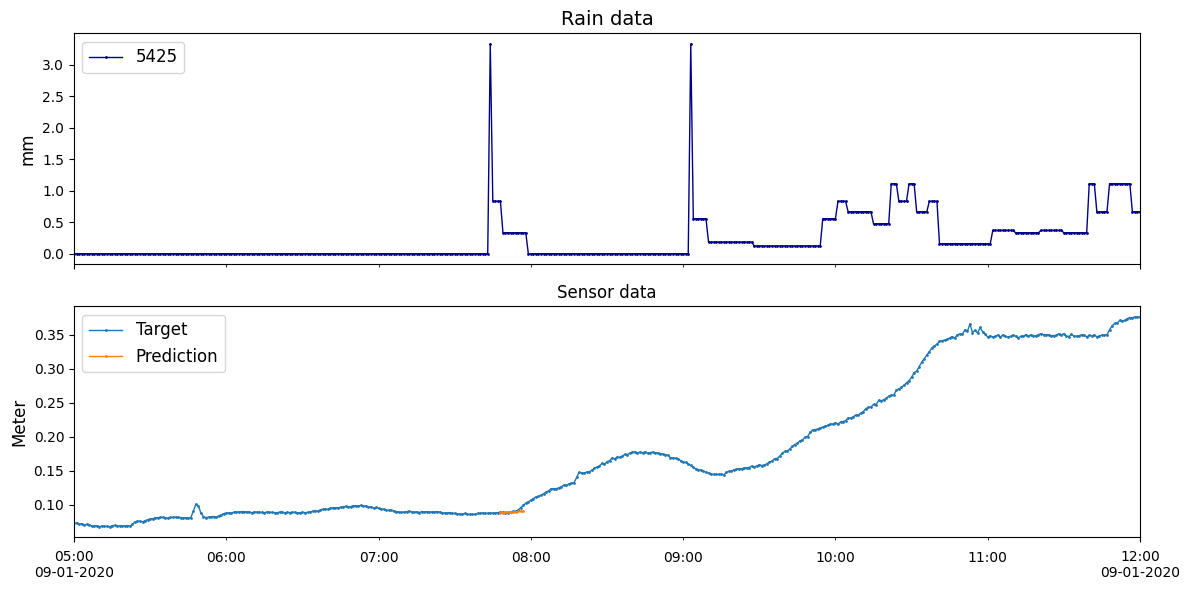

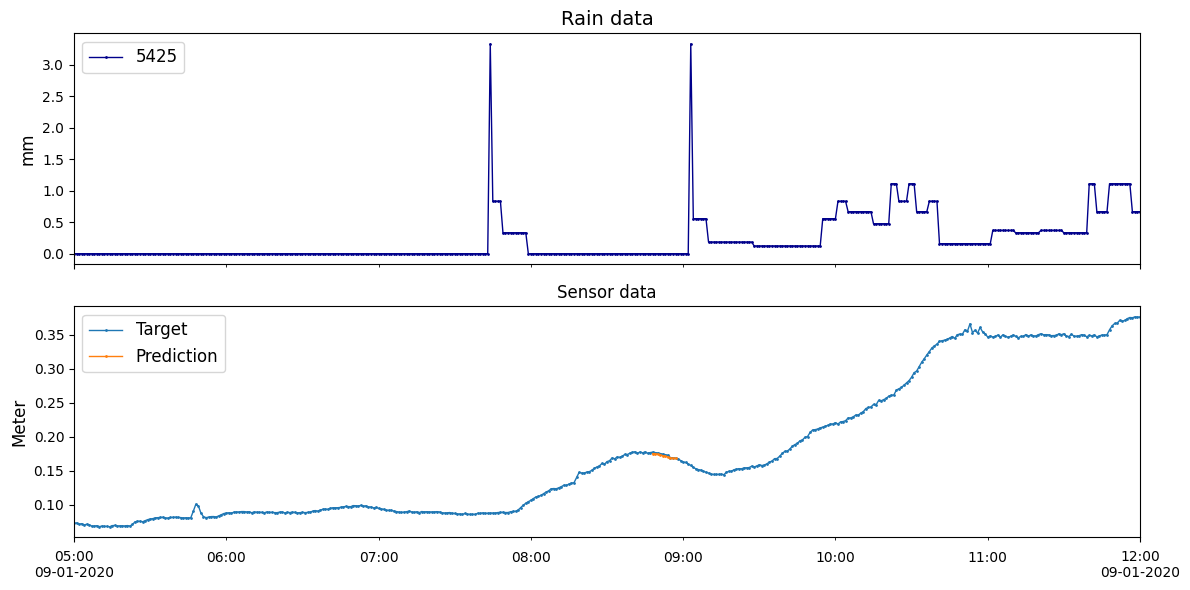

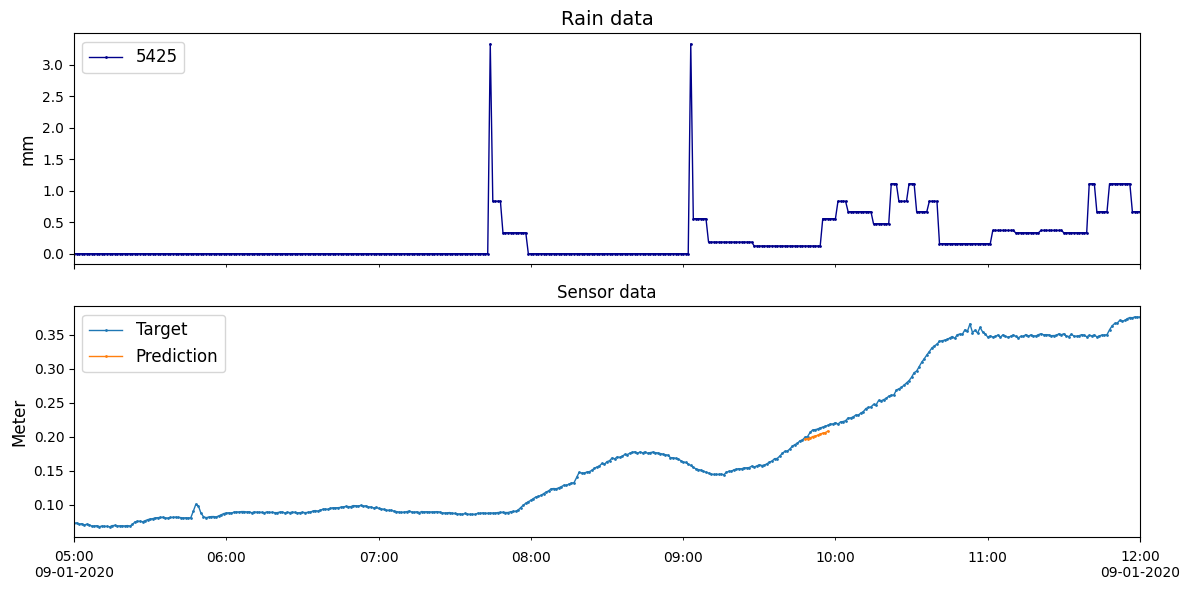

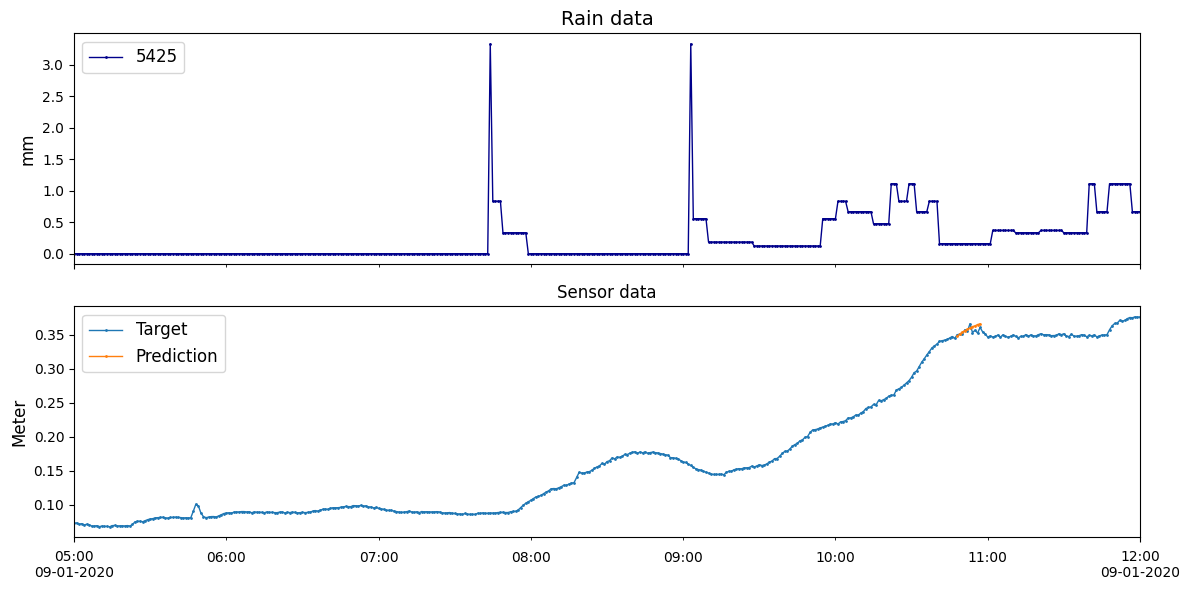

##################################################
Visualizing condition: Dry
##################################################


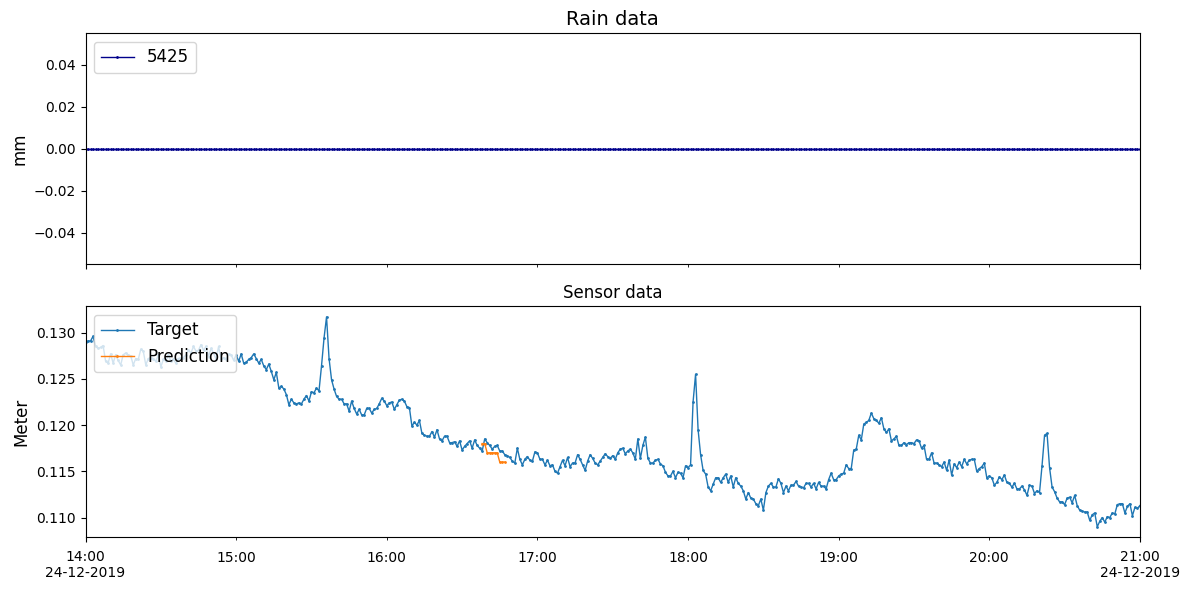

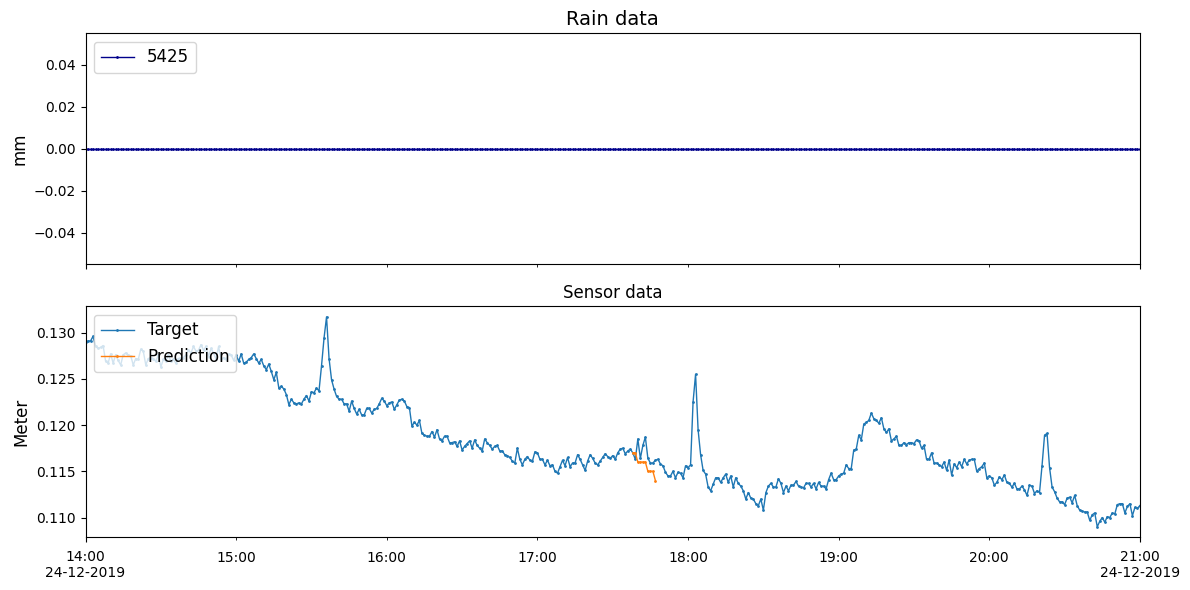

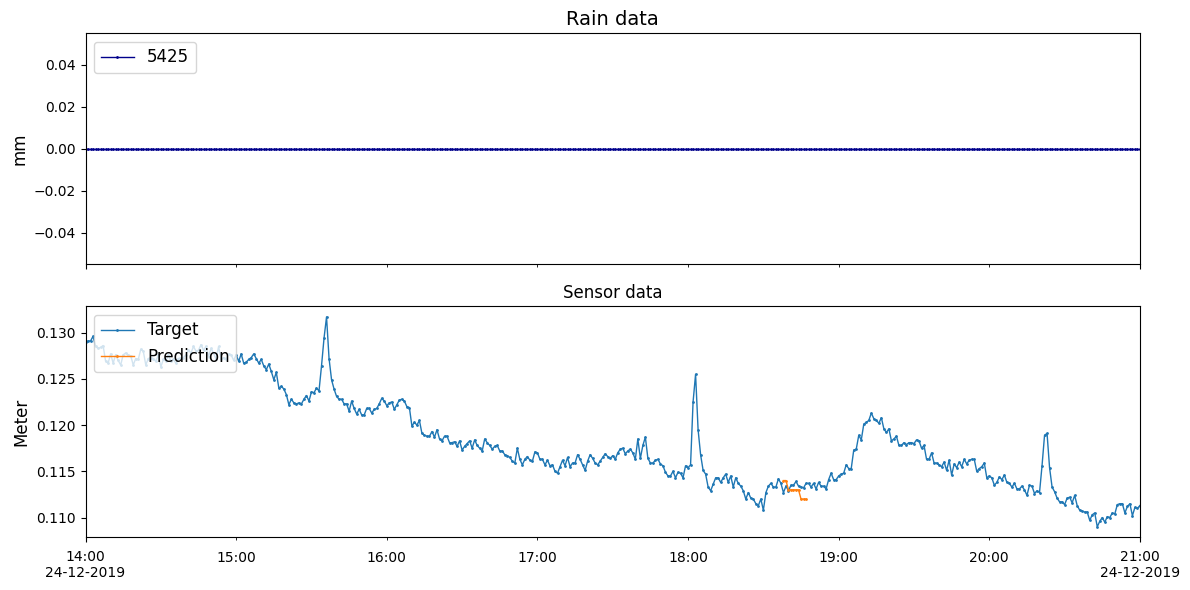

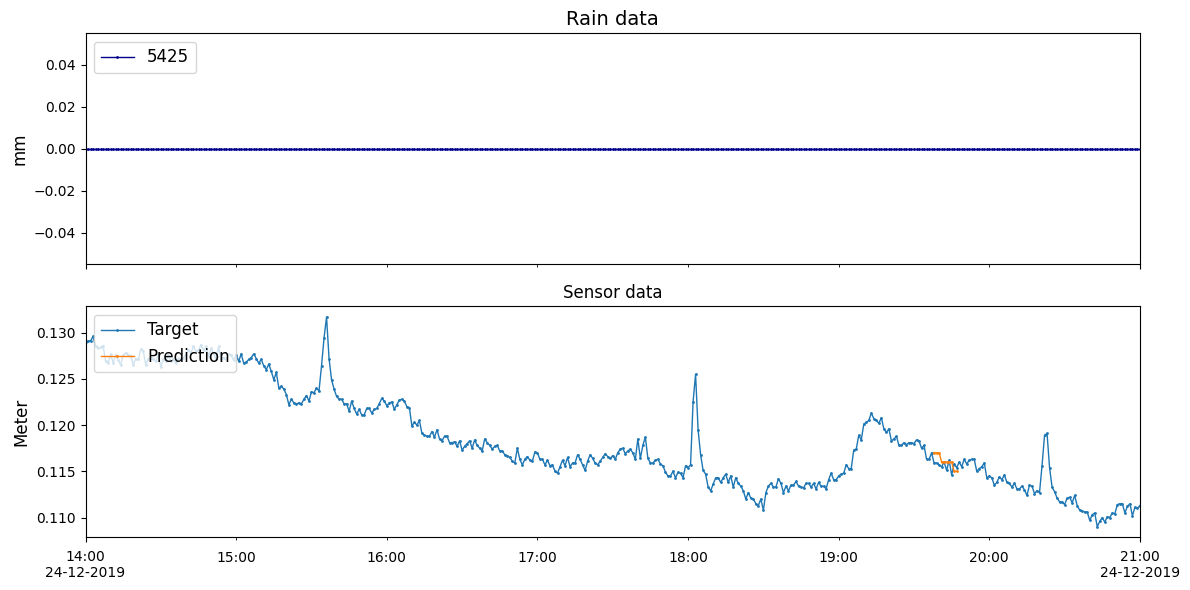

##################################################
Visualizing condition: Rain
##################################################
##################################################
Visualizing condition: Extreme
##################################################
##################################################
Visualizing condition: Dry
##################################################


In [183]:

example_folder = eval_folder / data_type / 'examples'
# os.makedirs(example_folder, exist_ok=True)

visualize_condition_events(example_folder, model, dataset, data, conditions, 
        config['predict_steps_ahead'], 
        scalers,
        metadata,
        n_events_per_condition=1,
        n_starts_per_event=3, # 3 starts per event, i.e. 3 predictions per event
        save_plots=False,
        )
visualize_condition_events(example_folder, model, dataset, data, conditions, 
        config['predict_steps_ahead'], 
        scalers,
        metadata,
        n_events_per_condition=1,
        n_starts_per_event=3,
        save_plots=True,
        )

### Visualize 3 examples of largest errors

In [184]:
# load the output
with open(eval_folder / data_type / f'output.pkl', 'rb') as f:
    output = pickle.load(f)


In [185]:
print(output.keys())

# calculate the abs of sum of steps ahead residuals
acc_residuals = (abs(output["targets"] - output["predictions"])).mean(axis=2)
timestamps = output['timestamps']


#del output

dict_keys(['predictions', 'targets', 'endogenous_vars', 'timestamps'])


In [186]:

# Assuming acc_residuals is a 1D or 2D numpy array and timestamps is the corresponding datetime array
top_k = 5
# Flatten the residuals just in case it's multi-dimensional
flattened_residuals = acc_residuals.flatten()

# Create a DataFrame to help manage dates and residuals
_data = {'start': timestamps, 'residual': flattened_residuals}
df = pd.DataFrame(_data)

# Convert timestamp to datetime if it's not already
df['start'] = pd.to_datetime(df['start'])

# Extract the date part from the timestamp
df['date'] = df['start'].dt.date

# Get the index of the maximum residual for each unique date
idx = df.groupby('date')['residual'].idxmax()

# Select the top residuals and corresponding timestamps
top_residuals = df.loc[idx].nlargest(top_k, 'residual')

# Print the results
for i, (residual, start) in enumerate(zip(top_residuals['residual'], top_residuals['start'])):
    print(f"Top {i+1} residual: {residual:.5f} at {start}")
# turn both into df


Top 1 residual: 0.31370 at 2020-07-27 14:07:00
Top 2 residual: 0.19350 at 2021-07-08 22:18:00
Top 3 residual: 0.18940 at 2021-07-31 12:07:00
Top 4 residual: 0.18290 at 2021-08-16 11:30:00
Top 5 residual: 0.16700 at 2021-07-28 18:00:00


In [187]:
# rename
top_residuals

,start,residual,date
312167,2020-07-27 14:07:00,0.3137,2020-07-27
808017,2021-07-08 22:18:00,0.1935,2021-07-08
840526,2021-07-31 12:07:00,0.1894,2021-07-31
863529,2021-08-16 11:30:00,0.1829,2021-08-16
836559,2021-07-28 18:00:00,0.1670,2021-07-28


Residual: 0.31370 at 2020-07-27 14:07:00


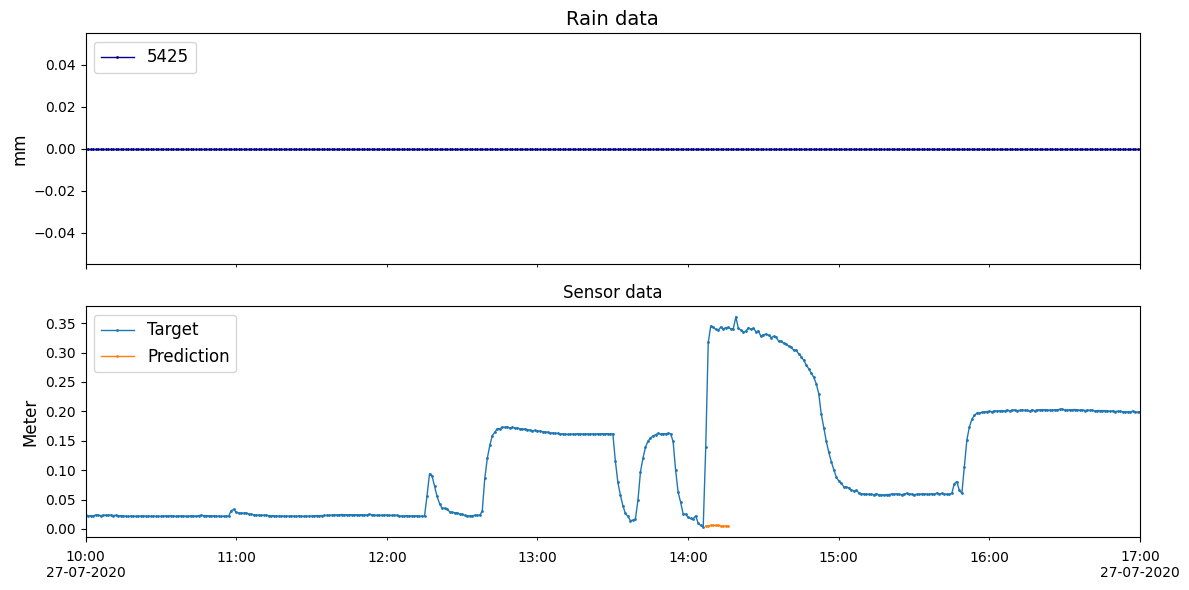

Residual: 0.19350 at 2021-07-08 22:18:00


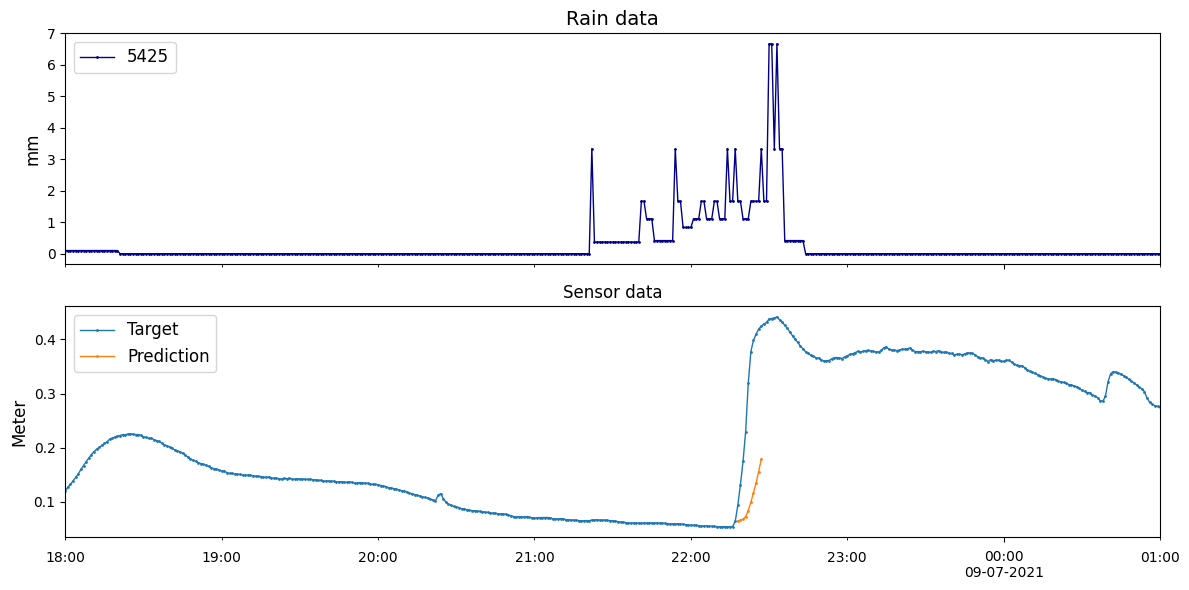

Residual: 0.18940 at 2021-07-31 12:07:00


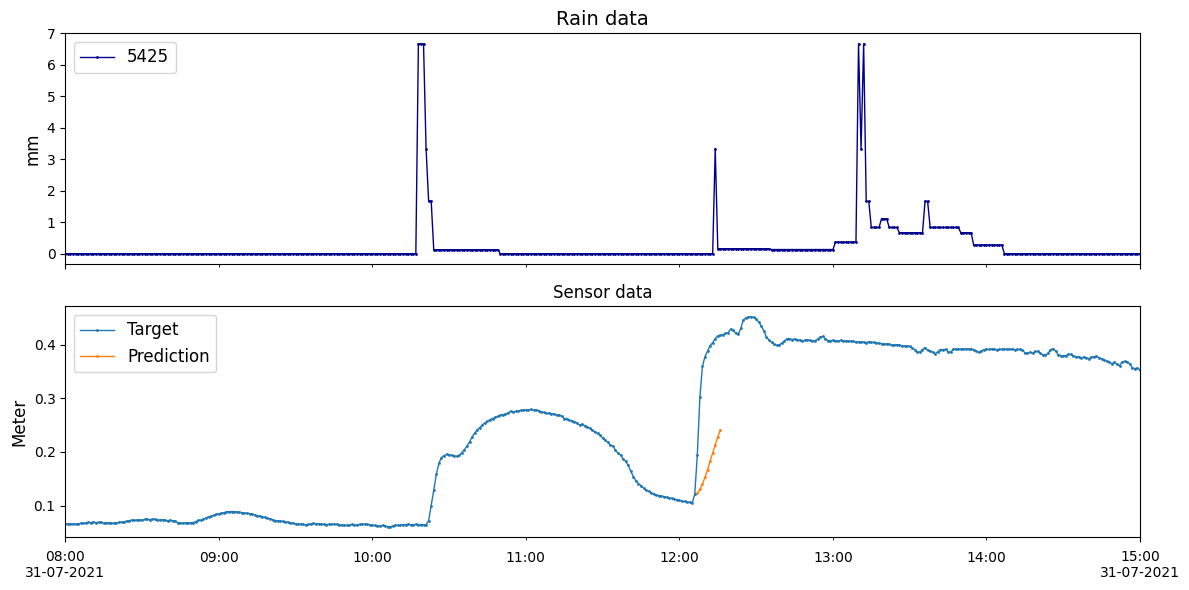

Residual: 0.18290 at 2021-08-16 11:30:00


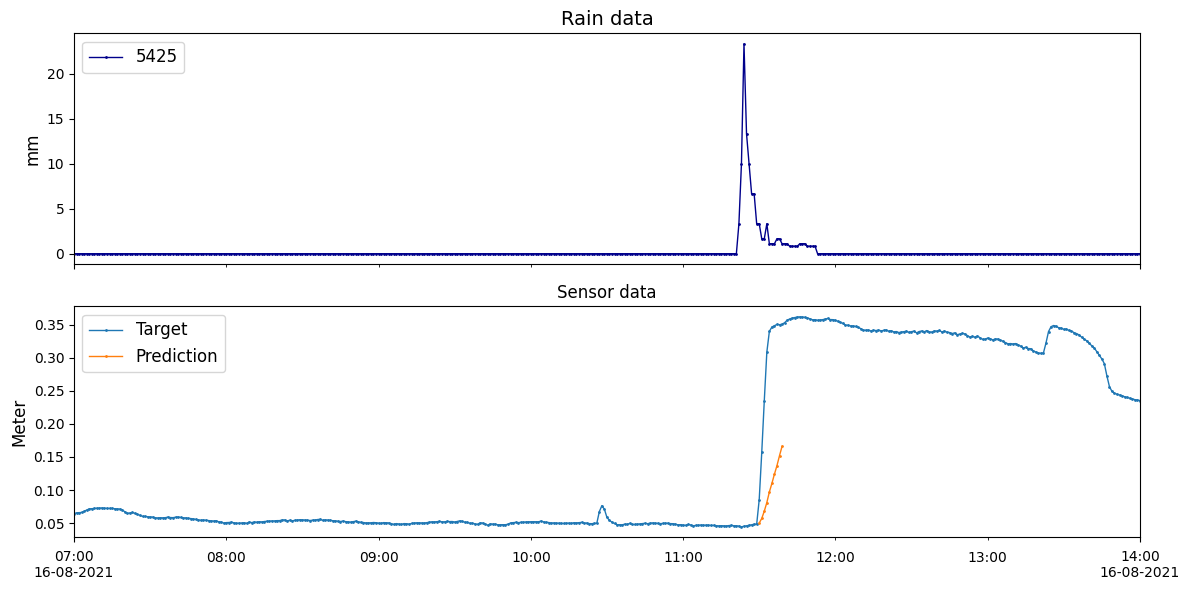

Residual: 0.16700 at 2021-07-28 18:00:00


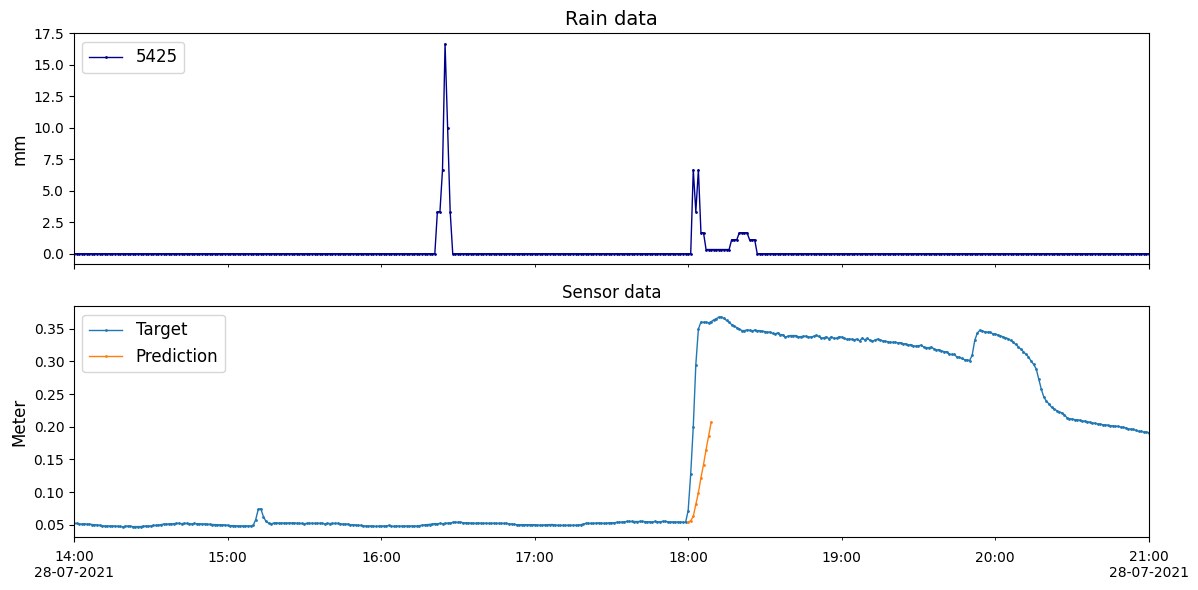

In [188]:

# Define event period to visualize
look_back_min = dataset.sequence_length
look_forward_min = 60 + config['predict_steps_ahead'] # 1 hour ahead

# iterate over the events
for _, event in top_residuals.iterrows():
    # the average 10 steps ahead residual
    print(f"Residual: {event['residual']:.5f} at {event['start']}")
    # Get the prediction data
    pred_timestamps = pd.date_range(event['start'], periods=config['predict_steps_ahead'], freq='1min')
    # get index in output
    idx_start = np.where(output['timestamps'] == event['start'])[0][0]
    prediction = output['predictions'][idx_start].flatten()
    #raise NotImplementedError("Need to get the data for the event")

    # Get the plot data
    start, end = event['start']-pd.Timedelta(hours=2), event['start']+pd.Timedelta(hours=1) # from start and to start + 3 hours for fixed duration
    start = (pd.to_datetime(start) - pd.Timedelta(minutes=look_back_min)).floor('1h')
    end = (pd.to_datetime(end) + pd.Timedelta(minutes=look_forward_min)).ceil('1h')
    event_timestamps = pd.date_range(start, end, freq='1min')
    event_data = data.loc[start:end]
    # ensure the event data has 1 minute values (if not set values to nan)
    event_data = event_data.reindex(event_timestamps)

    for i, endogenous_var in enumerate(dataset.endogenous_vars):
        # Create a folder for each sensor
        sensor_folder = example_folder / endogenous_var
        os.makedirs(sensor_folder, exist_ok=True)

        # Visualize
        exogenous_vars = ["5425"] # only want rain, else use dataset.exogenous_vars
        
        fig, ax = visualize_prediction(event_data[endogenous_var], event_data[exogenous_vars], 
                                       pred_timestamps, prediction, 
                                       metadata)
        
        start_str = start.strftime("%Y-%m-%d")
        plt.tight_layout()
        res = round(event['residual'], 4)
        # both visualize and save
        plt.show()
        fig.savefig(sensor_folder / f"avg10res={res}_{start_str}.png", dpi=150)
        plt.close(fig)

        